# KNN (K-Nearest-Neighbors) Machine Learning Algorithm on Gulf of Mexico Regional Lease Sales

In this study we use k-Nearest Neighbor classification method to see if we can predict the outcome of offshore lease sales in Unite States Gulf of Mexico. Explanatory features selected here are water depth, historic lease sale, historic bonuses paid, working interests and companies participated.

Source: https://www.boem.gov/Gulf-of-Mexico-Region-Leasing-Information/

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

path1 = ("deleted C:/lease_data_for_knn4.csv")
ratings = pd.read_csv(path1, sep=',')
ratings.head(2)

,block_id_num,block,bonus_mill,pre_1990,1990_2000,2000_2010,2010_2018,0_1k_wd,1k_2k_wd,2k_3k_wd,...,Statoil,Chevron,BHP,Shell,BP,Exxon,ENI,Total,major_comp,wd_ft
0,1,AC 0024,0.201,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,4842
1,2,AC 0025,3.232,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,4793


Below we group everything by block IDs and compute the total number of ratings (bonuses paid in $mill) and the average rating for every block:

In [46]:
BlockProperties = ratings.groupby('block_id_num').agg({'bonus_mill': [np.size, np.mean]})
BlockProperties.head(3)

bonus_mill       
                   size   mean
block_id_num                  
1                   1.0  0.201
2                   2.0  3.232
3                   2.0  0.601

The raw number of ratings or bonuses paid are useful for computing distances between blocks, however because these amounts are paid over time based on different circumstance such as prevalent oil price or geological understanding of that area, it is better we normalize them. Below we create a new DataFrame that contains the normalized number of ratings. So, a value of 0 means no company paid any amount, and a value of 1 will mean it's the most attractive block within that lease sale.

In [47]:
BlockNumRatings = pd.DataFrame(BlockProperties['bonus_mill']['size'])
BlockNormalizedNumRatings = BlockNumRatings.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
BlockNormalizedNumRatings.head()

,size
block_id_num,
1,0.000000
2,0.033333
3,0.033333
4,0.000000
5,0.000000


Next we import features such as different levels of water depth, working interests and names of major oil companies that particiapted in the lease sales over years.

In [48]:
with open(path1) as f:
    next(f, None) # Skip heading
    temp = ''
    for line in f:
        fields = line.rstrip('\n').split(',')
        BlockID = int(fields[0])
        name = fields[1]

In [49]:
BlockDict = {}
with open(path2) as f:
    next(f, None) # Skip heading
    temp = ''
    for line in f:
        fields = line.rstrip('\n').split(',')
        BlockID = int(fields[0])
        Blockname = fields[1]
        features = fields[3:23]
        features = list(map(int, features))
        BlockDict[BlockID] = (Blockname, features, BlockNormalizedNumRatings.loc[BlockID].get('size'), BlockProperties.loc[BlockID].bonus_mill.get('mean'))


Next we define a function that measures the "distance" (=similarity) between two blocks based on how similar their features are, and how similar their bonus payment is. We test this on two block ID's 2 and 4:

In [50]:
from scipy import spatial

def ComputeDistance(a, b):
    featuresA = a[1]
    featuresB = b[1]
    BlockDistance = spatial.distance.cosine(featuresA, featuresB)
    popularityA = a[2]
    popularityB = b[2]
    popularityDistance = abs(popularityA - popularityB)
    return BlockDistance + popularityDistance
    
ComputeDistance(BlockDict[2], BlockDict[4])  # Measure the distance between block IDs 2 and 4


1.0333333333333334

Mind the higher the distance, the less similar the blocks are. Next we check what blocks 2 and 4 actually are - and confirm they're not really all that similar:

Next we compute the distance between some given test blocks and all of the blocks in our data set. Then we sort those by distance, and print out the K nearest neighbors:

In [51]:
import operator

def getNeighbors(BlockID, K): # One measure of distance
    distances = []
    for Block in BlockDict:
        if (Block != BlockID):
            dist = ComputeDistance(BlockDict[BlockID], BlockDict[Block])
            distances.append((Block, dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(K):
        neighbors.append(distances[x][0])
    return neighbors

In [52]:
K = 10
avgRating = 0
neighbors = getNeighbors(1322, K)       # Testing block #20 with K=3
for neighbor in neighbors:
    avgRating += BlockDict[neighbor][3]
    print (BlockDict[neighbor][0] + ' ' + str(BlockDict[neighbor][3]))

avgRating = float(K)

AC 0817 0.754196
AC 0861 0.781579
GC 0845 1.546207
GC 0846 1.421691
GC 0847 0.749608
GC 0848 0.997122
GC 0890 1.215308
GC 0891 0.749608
GC 0993 0.615
KC 0084 0.749608


Our choice of 10 for K was arbitrary - what effect do different K values have on the results?

Our distance metric was also somewhat arbitrary - we just took the cosine distance between the blocks and added it to the difference between the normalized popularity scores. Can you improve on that?

<h3> Let's try sklearn and see if we can predict major oil companies' behavior using features of water depth and amount of bonuses paid. The deeper the water depth the more capital intensive and technologically complex a discovery will be. Such discoveries are usually manageable only by major oil companies.</h3>

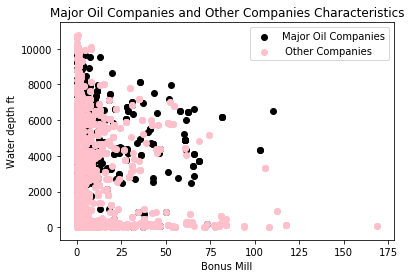

In [53]:
# Looking at data

plt.scatter(
    ratings[ratings['major_comp'] == 1].bonus_mill,
    ratings[ratings['major_comp'] == 1].wd_ft,
    color= 'black'
)
plt.scatter(
    ratings[ratings['major_comp'] == 0].bonus_mill,
    ratings[ratings['major_comp'] == 0].wd_ft,
    color='pink'
)
     
plt.legend(['Major Oil Companies', ' Other Companies'])
plt.title('Major Oil Companies and Other Companies Characteristics')
plt.xlabel('Bonus Mill')
plt.ylabel('Water depth ft')
plt.show()

In [54]:
# Below we select a subset of original features table
df = pd.concat([ratings.ix[:,2],ratings.ix[:,25], ratings.ix[:,24]], axis=1)

C:\Users\aath\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [55]:
df.head()

,bonus_mill,wd_ft,major_comp
0,0.201,4842,1
1,3.232,4793,1
2,3.232,4793,1
3,0.601,4583,1
4,0.601,4583,1


In [56]:
X0 = df.iloc[:,0:2] # Bonus paid and water depth of lease block
Y = df.iloc[:,2]  # 1 if lease bidder was a major oil company and 0 otherwise

In [57]:
# Here we normalize X values 
from sklearn import preprocessing

x = X0.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X0 = pd.DataFrame(x_scaled)

In [58]:
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats

# Fit the model
neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(X0,Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

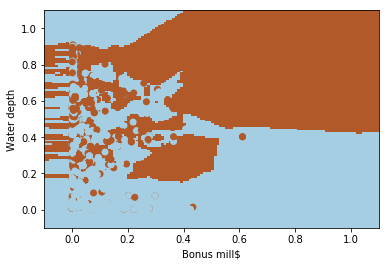

In [59]:
# Arrays, not data frames, for the mesh.
X = np.array(X0)
Y = np.array(Y)

# Mesh size.
h = 0.01

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X[:,0].min() - .1
x_max = X[:,0].max() + .1
y_min = X[:,1].min() - .1
y_max = X[:,1].max() + .1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Bonus mill$')
plt.ylabel('Water depth')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

We do not see a clear boundry on lower side of water depth and bonus payments. However, on the higher side, we see a tendency that major oil companies are the most active players in that space. 

# Let's try KNN Regression on water depth and bonus paid

In [60]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(df.wd_ft)

Y = df.bonus_mill
knn.fit(X, Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

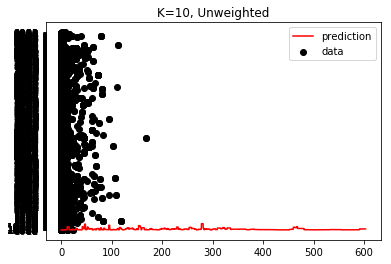

In [61]:
# Set up our prediction line.
T = np.arange(0, 602.8, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_=knn.predict(T)

#Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)
plt.scatter(Y, X, c='k', label='data')
plt.plot(T, Y_, c='r', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

# Deeper water depth (x-axis) is not an indicator of more bonus paid for the lease sale. 

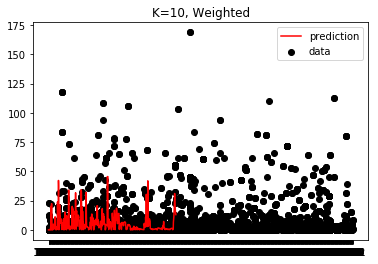

In [62]:
# Run the same model, this time with weights.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
X = pd.DataFrame(df.wd_ft)
Y = df.bonus_mill
knn_w.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 602.8, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='r', label='prediction')
plt.legend()
plt.title('K=10, Weighted')
plt.show()

# Adding weighted average improves the model. Next we validate the model using cross validation. 

In [63]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(knn, X, Y, cv=5)
print("k= 5 Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

k= 5 Accuracy: -0.38 (+/- 0.52)
Weighted Accuracy: -0.59 (+/- 0.74)


<h2> Both of these models performed poorly.<h2>

<h2> Previously we used KNN regression and next we use OLS on same data set.</h2>

In [64]:
import statsmodels.api as sm

X = pd.DataFrame(df.wd_ft)
Y = df.bonus_mill
sm_OLS_test = sm.OLS(Y, X) 

In [65]:
full_res = sm_OLS_test.fit() 
print ("\n \n",full_res.summary()) 


 
                             OLS Regression Results                            
Dep. Variable:             bonus_mill   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     383.1
Date:                Thu, 14 Jun 2018   Prob (F-statistic):           9.32e-83
Time:                        08:53:10   Log-Likelihood:                -24474.
No. Observations:                6028   AIC:                         4.895e+04
Df Residuals:                    6027   BIC:                         4.896e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
wd_ft          0.0009    4.5e-05     19.573     

<h2> OLS has also a very low R^2 indicating under fitting problem. </h2>

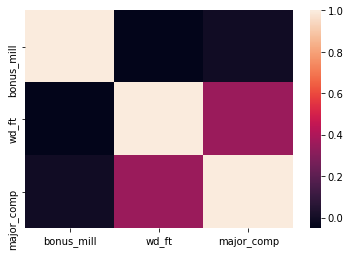

In [66]:
import seaborn as sns
# Below correlation matrix shows a moderate linear relationship between water depth and being a major oil company
sns.heatmap(df.corr())

<h3> Using both models we can say that KNN and OLS learning algorithms are not good for this problem. Maybe our hypothesis space is too small for them to explores and learn? A possible improvement for future analysis is to engineer new features from existing ones and/or use more parameters helping to expand the hypothesis space.   </h3>